# Intel Image Classification

By Aviya Oren and Maya Hayat

This Data contains around 25k images of size 150x150 distributed under 6 categories.
1. 'buildings'
2. 'forest'
3. 'glacier'
4. 'mountain'
5. 'sea'
6. 'street'

In [3]:
import numpy as np
import pandas as pd
import os
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from PIL import Image
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import random

import cv2
import imghdr
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

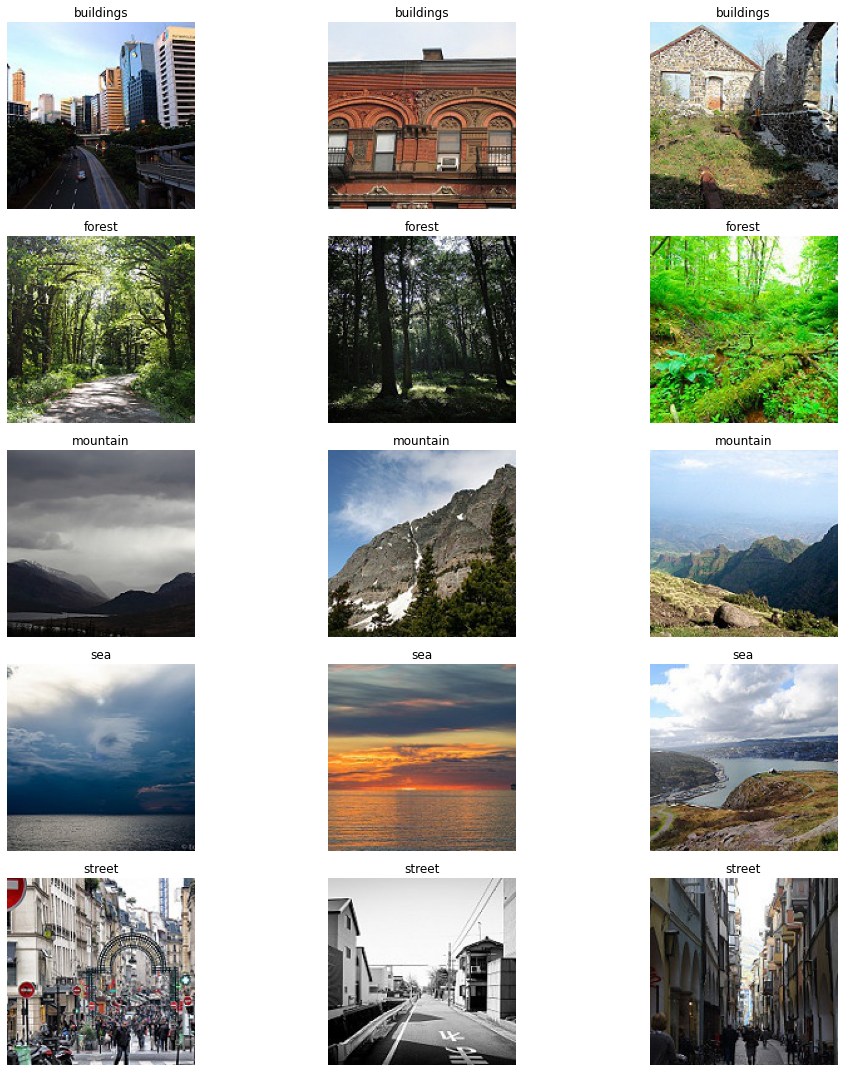

In [3]:
# Path to the directory containing the images
base_directory =  r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\seg_train\seg_train'

# Categories
categories = ['buildings', 'forest', 'mountain', 'sea', 'street']

# Display three random images for each category
fig, axs = plt.subplots(len(categories), 3, figsize=(15, 15))

for i, category in enumerate(categories):
    category_directory = os.path.join(base_directory, category)
    files = os.listdir(category_directory)
    image_files = [file for file in files if file.endswith(('png', 'jpg', 'jpeg'))]
    random_images = random.sample(image_files, 3)

    for j, image_file in enumerate(random_images):
        image_path = os.path.join(category_directory, image_file)
        image = mpimg.imread(image_path)
        axs[i, j].imshow(image)
        axs[i, j].axis('off')
        axs[i, j].set_title(category)

plt.tight_layout()
plt.show()


In [148]:
data_directory = r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\seg_train\seg_train'

In [149]:
test_data = r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\seg_test\seg_test'

In [150]:
os.listdir(data_directory)

['buildings', 'forest', 'mountain', 'sea', 'street']

In [151]:
os.listdir(test_data)

['buildings', 'forest', 'mountain', 'sea', 'street']

In [18]:
# According to Kaggle the original size if 150*150, therefore we want to keep it as is
data = tf.keras.utils.image_dataset_from_directory(r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\seg_train\seg_train', image_size = (150,150), batch_size=128)

Found 11630 files belonging to 5 classes.


In [19]:
test = tf.keras.utils.image_dataset_from_directory(r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\seg_test\seg_test', image_size = (150,150), batch_size=128)

Found 2447 files belonging to 5 classes.


In [20]:
data_iterator = data.as_numpy_iterator()
test_iterator = test.as_numpy_iterator()

In [155]:
batch = data_iterator.next()

In [13]:
batch[1]

array([1, 4, 3, 3, 4, 3, 2, 0, 1, 1, 2, 2, 4, 4, 4, 2, 1, 3, 0, 4, 4, 3,
       2, 1, 3, 3, 2, 4, 4, 0, 4, 3, 2, 0, 3, 1, 0, 2, 3, 0, 0, 4, 3, 4,
       4, 0, 1, 4, 1, 4, 2, 2, 3, 3, 2, 2, 3, 3, 1, 0, 3, 0, 1, 0, 2, 0,
       1, 1, 0, 0, 3, 0, 4, 1, 3, 2, 3, 0, 4, 2, 4, 0, 1, 1, 1, 3, 2, 3,
       0, 4, 4, 0, 4, 4, 0, 4, 1, 3, 4, 1, 1, 1, 1, 4, 2, 0, 2, 3, 2, 3,
       1, 2, 1, 1, 3, 1, 3, 3, 2, 3, 1, 2, 2, 4, 1, 2, 2, 2])

In [21]:
batch_test = test_iterator.next()

In [156]:
# where the first batch is our data and the second is the labels
len(batch),len(batch_test)

(2, 2)

In [157]:
batch[0].shape

(128, 150, 150, 3)

In [158]:
batch_test[0].shape

(128, 150, 150, 3)

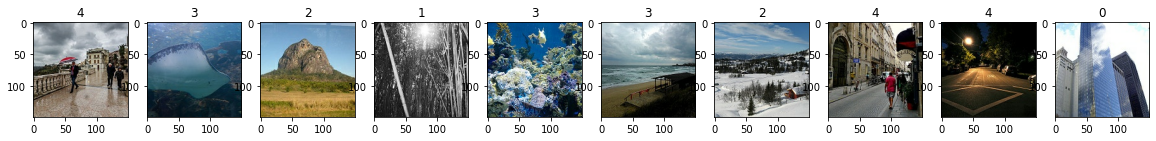

In [19]:
fig, ax = plt.subplots(ncols=10, figsize=(20,20))
offset = 20
for idx, img in enumerate(batch[0][offset:offset+10]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][offset+idx])

As we can see above the following numbers match the following catagories:

0. building
1. forest
2. mountain
3. sea
4. street

In [20]:
print("max:" , batch[0].max(), " and min: ", batch[0].min())

max: 255.0  and min:  0.0


In [21]:
data = data.map(lambda x, y: (x / 255.0, y))

In [22]:
test = test.map(lambda x, y: (x / 255.0, y))

In [23]:
data.as_numpy_iterator().next()[0].max(), data.as_numpy_iterator().next()[0].min()

(1.0, 0.0)

In [24]:
train_size = int(len(data)*0.8)
val_size = int(len(data)*0.2)

In [25]:
print(train_size, val_size)

72 18


In [26]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)

In [201]:
# Number of batches * 32 images
len(train), len(val), len(test)

(72, 18, 20)

In [5]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

In [28]:
model= tf.keras.Sequential([
    # First layer
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    # Second layer
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Third layer
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [29]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

In [4]:
logdir = r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\Log'

In [5]:
from keras.callbacks import EarlyStopping
callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Combine the TensorBoard callback with the EarlyStopping callback
callbacks = [callback, early_stopping]

In [34]:
history = model.fit(train, epochs=20, validation_data = val, callbacks=[callback])

Epoch 1/20
72/72 [==============================] - 225s 3s/step - loss: 0.9885 - accuracy: 0.5978 - val_loss: 0.8009 - val_accuracy: 0.6784
Epoch 2/20
72/72 [==============================] - 213s 3s/step - loss: 0.6525 - accuracy: 0.7476 - val_loss: 0.5686 - val_accuracy: 0.7843
Epoch 3/20
72/72 [==============================] - 213s 3s/step - loss: 0.5062 - accuracy: 0.8057 - val_loss: 0.4232 - val_accuracy: 0.8381
Epoch 4/20
72/72 [==============================] - 145s 2s/step - loss: 0.4103 - accuracy: 0.8486 - val_loss: 0.3928 - val_accuracy: 0.8511
Epoch 5/20
72/72 [==============================] - 155s 2s/step - loss: 0.3601 - accuracy: 0.8692 - val_loss: 0.3643 - val_accuracy: 0.8715
Epoch 6/20
72/72 [==============================] - 162s 2s/step - loss: 0.2845 - accuracy: 0.8992 - val_loss: 0.3249 - val_accuracy: 0.8841
Epoch 7/20
72/72 [==============================] - 191s 3s/step - loss: 0.2334 - accuracy: 0.9172 - val_loss: 0.3442 - val_accuracy: 0.8802
Epoch 8/20
72

In [35]:
model.save(r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\first_model_without_glacier.h5')

C:\Users\Maya\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


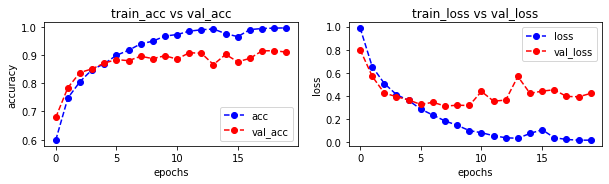

In [37]:
plot_accuracy_loss(history)

In [172]:
model = tf.keras.models.load_model(r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\first_model_without_glacier.h5')

In [174]:
from tensorflow.keras.metrics import CategoricalAccuracy

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

y_true_all = []
y_pred_all = []

for batch_test in test.as_numpy_iterator():
    X, y = batch_test
    print(y)
    yhat = model.predict(X, batch_size=128)
    y_pred = np.argmax(yhat,axis=1)
    print(y_pred)
    pre.update_state(y, y_pred)
    re.update_state(y, y_pred)
    y_true_one_hot = tf.one_hot(y, 6)
    acc.update_state(y_true_one_hot, yhat)
    y_true_all = np.concatenate([y_true_all, y])
    y_pred_all = np.concatenate([y_pred_all, y_pred])


[0 0 2 1 3 0 4 4 4 4 2 0 0 0 3 3 0 4 0 4 1 2 1 3 2 2 1 0 4 4 0 4 0 1 4 0 1
 1 4 3 0 3 3 0 3 4 1 2 4 2 1 0 2 0 2 3 2 4 3 2 3 0 1 0 0 3 3 0 2 1 1 1 0 3
 2 1 3 4 1 1 1 1 2 0 2 0 3 1 4 3 4 4 4 3 0 2 2 2 1 4 1 0 2 3 0 3 0 3 2 1 4
 3 4 2 2 1 4 4 4 2 2 4 1 0 0 3 0 2]
1/1 [==============================] - 1s 828ms/step
[0 0 2 1 3 4 4 1 0 4 2 0 0 0 2 3 0 4 0 0 1 2 1 3 2 2 1 0 4 4 0 4 0 1 0 0 1
 1 4 3 0 3 3 0 3 4 1 2 0 2 1 0 2 0 2 3 2 4 3 2 3 0 1 0 0 3 3 0 1 1 1 1 0 3
 2 1 2 4 1 1 1 1 2 0 2 0 3 1 4 3 4 0 0 3 0 2 2 2 1 4 2 0 2 3 0 2 0 3 2 1 4
 3 4 2 0 1 4 0 4 2 2 0 1 0 0 3 4 2]
[2 4 4 1 2 3 3 3 0 2 2 3 1 2 4 3 2 0 2 1 3 1 0 4 3 4 3 0 4 2 1 2 4 3 0 0 2
 0 0 2 3 3 1 1 3 0 3 2 3 1 1 2 0 3 0 4 0 1 3 2 0 3 1 4 3 0 0 0 4 4 1 0 1 0
 2 1 4 4 1 2 4 4 3 4 2 3 2 3 0 2 3 2 3 4 1 4 1 4 4 0 1 4 0 1 4 3 4 2 3 4 1
 0 3 2 1 3 3 2 3 2 2 0 1 0 2 2 3 3]
1/1 [==============================] - 1s 784ms/step
[2 0 4 1 2 2 2 3 0 2 2 2 1 2 2 3 2 0 2 1 0 1 0 1 3 4 3 2 1 2 1 2 4 3 0 0 2
 0 0 2 3 3 1 1 3 0 3 2 4 1 1 2 4 0 0

1/1 [==============================] - 1s 788ms/step
[2 4 3 0 0 0 3 1 1 1 3 4 2 3 2 0 4 3 2 2 0 0 3 2 0 2 0 2 1 0 1 0 2 4 0 4 1
 1 3 0 1 2 0 3 3 4 3 2 3 4 2 2 0 4 2 4 4 2 2 3 2 1 0 1 0 4 0 1 1 2 1 1 1 2
 0 1 0 2 0 3 2 4 2 2 3 4 2 1 0 1 1 1 2 3 2 1 2 2 4 4 3 4 4 4 2 3 2 2 2 3 2
 2 1 4 4 3 1 4 1 2 0 2 2 1 2 4 2 3]
[2 0 0 2 4 1 3 4 3 0 2 2 0 2 3 3 3 2 1 0 0 1 1 3 2 3 4 3 2 0 1 4 4 1 2 3 4
 0 2 4 2 0 3 4 0 2 0 2 4 4 3 2 2 0 2 2 4 2 3 0 4 2 0 4 4 4 3 2 1 2 0 3 2 3
 4 0 2 4 0 3 0 3 0 3 4 2 4 3 0 4 1 3 0 2 0 0 2 3 4 3 4 2 3 3 2 0 1 1 3 1 1
 1 2 3 4 0 0 4 0 3 4 3 1 4 1 0 4 4]
1/1 [==============================] - 1s 802ms/step
[2 0 1 2 4 1 3 0 3 0 2 2 0 2 3 3 2 2 1 4 0 4 1 3 2 3 4 0 2 0 1 4 4 1 2 3 4
 0 2 4 2 0 3 4 4 2 0 2 4 4 3 2 2 0 2 2 4 2 3 0 4 2 0 0 0 0 2 2 1 2 0 3 2 2
 4 0 0 0 0 3 0 3 2 3 4 2 4 0 4 4 1 3 0 2 0 2 2 3 0 3 4 2 3 3 2 0 4 1 3 1 1
 1 2 3 0 0 0 4 0 3 4 3 1 4 1 0 4 0]
[3 3 1 4 2 4 1 2 3 2 3 3 2 1 0 2 0 2 4 3 3 1 2 3 3 1 0 1 1 0 0 1 4 1 1 2 4
 3 3 3 4 2 1 0 2 4 0 3 3 1 1 1 0 1 2

In [175]:
print("Precision: {:.4f}, Recall: {:.4f}, Accuracy:{:.4f}".format(pre.result(), re.result(), acc.result()))

Precision: 0.9569, Recall: 0.9279, Accuracy:0.8145


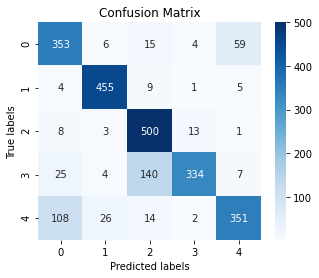

In [176]:
conf_matrix = confusion_matrix(y_true_all, y_pred_all)

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# VGG Model

In [42]:
from tensorflow.keras.applications import VGG16
model_vgg = VGG16(weights='imagenet', include_top = False, input_shape=(150, 150, 3))

In [43]:
model_vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [44]:
model_vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_vgg = model_vgg.fit(train, epochs=10, validation_data = val, callbacks=[callback])

Epoch 1/10
88/88 [==============================] - 4231s 49s/step - loss: 1.0840 - accuracy: 0.5823 - val_loss: 0.8714 - val_accuracy: 0.6639
Epoch 2/10
88/88 [==============================] - 597s 7s/step - loss: 0.7180 - accuracy: 0.7392 - val_loss: 0.7871 - val_accuracy: 0.7137
Epoch 3/10
88/88 [==============================] - 567s 6s/step - loss: 0.5998 - accuracy: 0.7805 - val_loss: 0.5671 - val_accuracy: 0.8000
Epoch 4/10
88/88 [==============================] - 566s 6s/step - loss: 0.5072 - accuracy: 0.8203 - val_loss: 0.5446 - val_accuracy: 0.8061
Epoch 5/10
88/88 [==============================] - 566s 6s/step - loss: 0.4128 - accuracy: 0.8521 - val_loss: 0.5334 - val_accuracy: 0.8137
Epoch 6/10
88/88 [==============================] - 562s 6s/step - loss: 0.3311 - accuracy: 0.8843 - val_loss: 0.5057 - val_accuracy: 0.8300
Epoch 7/10
88/88 [==============================] - 555s 6s/step - loss: 0.2692 - accuracy: 0.9090 - val_loss: 0.5036 - val_accuracy: 0.8354
Epoch 8/10


In [ ]:
model_vgg.save('vgg_model.h5')

In [178]:
# Load the saved model
model_vgg = tf.keras.models.load_model(r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\vgg_model.h5')

OSError: Unable to open file (truncated file: eof = 27262976, sblock->base_addr = 0, stored_eof = 29148200)

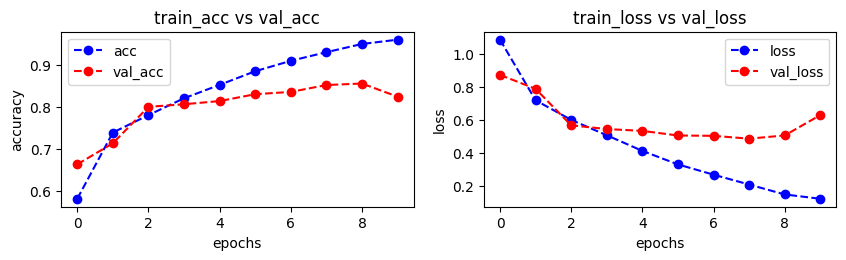

In [ ]:
plot_accuracy_loss(history_vgg)

In [ ]:
from tensorflow.keras.metrics import CategoricalAccuracy

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model_vgg.predict(X, batch_size=128)
    y_pred = np.argmax(yhat,axis=1)
    pre.update_state(y, y_pred)
    re.update_state(y, y_pred)
    y_true_one_hot = tf.one_hot(y, 6)
    acc.update_state(y_true_one_hot, yhat)


1/1 [==============================] - 1s 953ms/step


In [ ]:
print("Precision: {:.4f}, Recall: {:.4f}, Accuracy:{:.4f}".format(pre.result(), re.result(), acc.result()))

Precision: 0.9740, Recall: 0.9328, Accuracy:0.7881


In [ ]:
from tensorflow.keras.metrics import CategoricalAccuracy

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch_test
    yhat = model_vgg.predict(X, batch_size=128)
    y_pred = np.argmax(yhat,axis=1)
    pre.update_state(y, y_pred)
    re.update_state(y, y_pred)
    y_true_one_hot = tf.one_hot(y, 6)
    acc.update_state(y_true_one_hot, yhat)


1/1 [==============================] - 2s 2s/step


In [ ]:
print("Precision: {:.4f}, Recall: {:.4f}, Accuracy:{:.4f}".format(pre.result(), re.result(), acc.result()))

Precision: 0.9608, Recall: 0.8991, Accuracy:0.6172


In [ ]:
# Use the appropriate evaluation metric for your task (e.g., accuracy, precision, recall)
model_loss, model_accuracy = model_vgg.evaluate(test)
print(f"Test Loss: {model_loss}, Test Accuracy: {model_accuracy}")


24/24 [==============================] - 49s 2s/step - loss: 0.7879 - accuracy: 0.7881
Test Loss: 0.7879317998886108, Test Accuracy: 0.7880794405937195


In [ ]:
# Assuming you have loaded your model as model_vgg
history_vgg = model_vgg.fit(train, epochs=5, validation_data = val, callbacks=[callback])

Epoch 1/5
88/88 [==============================] - 1482s 17s/step - loss: 0.2151 - accuracy: 0.9324 - val_loss: 0.2031 - val_accuracy: 0.9336
Epoch 2/5
88/88 [==============================] - 673s 8s/step - loss: 0.1127 - accuracy: 0.9660 - val_loss: 0.1718 - val_accuracy: 0.9480
Epoch 3/5
88/88 [==============================] - 629s 7s/step - loss: 0.0679 - accuracy: 0.9825 - val_loss: 0.1716 - val_accuracy: 0.9520
Epoch 4/5
88/88 [==============================] - 676s 8s/step - loss: 0.0552 - accuracy: 0.9852 - val_loss: 0.1969 - val_accuracy: 0.9430
Epoch 5/5
88/88 [==============================] - 666s 8s/step - loss: 0.0402 - accuracy: 0.9904 - val_loss: 0.2386 - val_accuracy: 0.9343


In [ ]:
model_vgg.save('vgg_model_5epochs.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


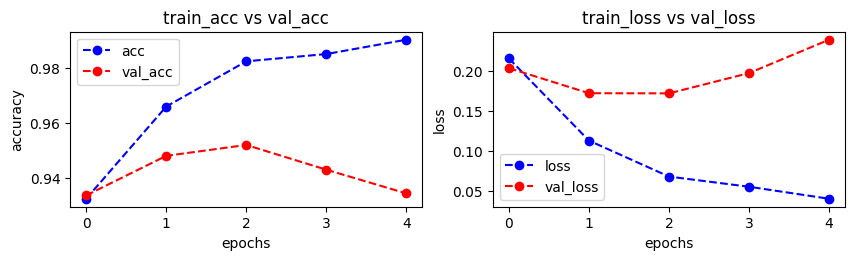

In [ ]:
plot_accuracy_loss(history_vgg)

In [ ]:
from tensorflow.keras.metrics import CategoricalAccuracy

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch_test
    yhat = model_vgg.predict(X, batch_size=128)
    y_pred = np.argmax(yhat,axis=1)
    pre.update_state(y, y_pred)
    re.update_state(y, y_pred)
    y_true_one_hot = tf.one_hot(y, 6)
    acc.update_state(y_true_one_hot, yhat)


1/1 [==============================] - 1s 1s/step


In [ ]:
print("Precision: {:.4f}, Recall: {:.4f}, Accuracy:{:.4f}".format(pre.result(), re.result(), acc.result()))

Precision: 0.9706, Recall: 0.9083, Accuracy:0.6797


In [ ]:
# Use the appropriate evaluation metric for your task (e.g., accuracy, precision, recall)
model_loss, model_accuracy = model_vgg.evaluate(test)
print(f"Test Loss: {model_loss}, Test Accuracy: {model_accuracy}")


24/24 [==============================] - 48s 2s/step - loss: 0.9008 - accuracy: 0.8142
Test Loss: 0.9008198976516724, Test Accuracy: 0.814238429069519


# Try to improve our VGG model

In [45]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense

# Load the VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# # Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

In [47]:
# Create the head model
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(6, activation='softmax')(x) 

In [48]:
# Combine the base and head models
model_vgg_impr = Model(inputs=base_model.input, outputs=output)

In [49]:
# Compile the model
model_vgg_impr.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_vgg_impr.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [51]:
history_vgg_impr = model_vgg_impr.fit(train, epochs=10, validation_data = val, callbacks=[callbacks])

Epoch 1/10
72/72 [==============================] - 917s 13s/step - loss: 0.4075 - accuracy: 0.8490 - val_loss: 0.2520 - val_accuracy: 0.9084
Epoch 2/10
72/72 [==============================] - 944s 13s/step - loss: 0.1803 - accuracy: 0.9340 - val_loss: 0.2238 - val_accuracy: 0.9180
Epoch 3/10
72/72 [==============================] - 821s 11s/step - loss: 0.1315 - accuracy: 0.9555 - val_loss: 0.1988 - val_accuracy: 0.9275
Epoch 4/10
72/72 [==============================] - 810s 11s/step - loss: 0.0982 - accuracy: 0.9680 - val_loss: 0.1720 - val_accuracy: 0.9358
Epoch 5/10
72/72 [==============================] - 885s 12s/step - loss: 0.0711 - accuracy: 0.9792 - val_loss: 0.1890 - val_accuracy: 0.9306
Epoch 6/10
72/72 [==============================] - 937s 13s/step - loss: 0.0758 - accuracy: 0.9750 - val_loss: 0.2149 - val_accuracy: 0.9319
Epoch 7/10
72/72 [==============================] - 970s 13s/step - loss: 0.0533 - accuracy: 0.9837 - val_loss: 0.1950 - val_accuracy: 0.9392


In [52]:
model_vgg_impr.save(r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\vgg_model_impr_withoutglacier.h5')

In [182]:
model_vgg_impr = tf.keras.models.load_model(r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\vgg_model_impr_withoutglacier.h5')

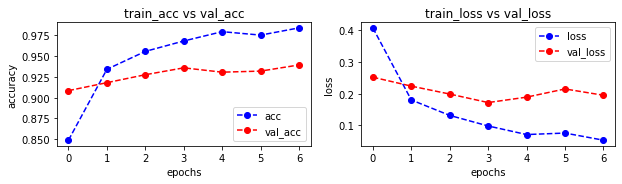

In [53]:
plot_accuracy_loss(history_vgg_impr)

In [183]:
from tensorflow.keras.metrics import CategoricalAccuracy

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

y_true_all = []
y_pred_all = []

for batch_test in test.as_numpy_iterator():
    X, y = batch_test
    yhat = model_vgg_impr.predict(X, batch_size=128)
    y_pred = np.argmax(yhat,axis=1)
    pre.update_state(y, y_pred)
    re.update_state(y, y_pred)
    y_true_one_hot = tf.one_hot(y, 6)
    acc.update_state(y_true_one_hot, yhat)
    y_true_all = np.concatenate([y_true_all, y])
    y_pred_all = np.concatenate([y_pred_all, y_pred])
    


1/1 [==============================] - 2s 2s/step


In [184]:
print("Precision: {:.4f}, Recall: {:.4f}, Accuracy:{:.4f}".format(pre.result(), re.result(), acc.result()))

Precision: 0.9803, Recall: 0.9393, Accuracy:0.8517


In [62]:
# Use the appropriate evaluation metric for your task (e.g., accuracy, precision, recall)
model_loss, model_accuracy = model_vgg_impr.evaluate(test)
print(f"Test Loss: {model_loss}, Test Accuracy: {model_accuracy}")


20/20 [==============================] - 214s 11s/step - loss: 0.2377 - accuracy: 0.9260
Test Loss: 0.23765453696250916, Test Accuracy: 0.9260318875312805


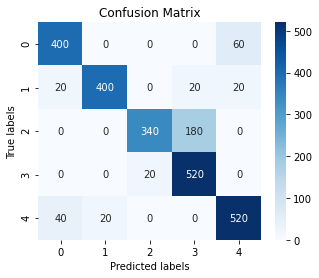

In [78]:
conf_matrix = confusion_matrix(y_true_all, y_pred_all)

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

We can see a slight confusion between the building and street which is due to their similarities (even a human eye would have a hard time classifying some of the images presented). 
The other main confusion though is between the mountains and see which caused by the fact that they probabily both consisting of a lot of blue thereofore the model might have a difficulty classifying those 2.

# Fine tuning VGG16 model

In [92]:
# Load the VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# # Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

In [93]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


In [94]:
# Create the head model
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(6, activation='softmax')(x) 

In [95]:
# Combine the base and head models
model_vgg_find_tuned = Model(inputs=base_model.input, outputs=output)

In [96]:
import tensorflow as tf

# Define initial learning rate
initial_learning_rate = 0.0001

# Define decay rate and decay steps
decay_rate = 0.95  # Example decay rate (experiment with different values)
decay_steps = 30  # Example decay steps (adjust based on your training regime)

# Create the learning rate decay schedule
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_rate=decay_rate,
    decay_steps=decay_steps,
    staircase=True  # Set to True for discrete decay at each step
)


In [97]:
# Choose the optimizer (e.g., RMSprop, Adam)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

# Compile the model
model_vgg_find_tuned.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)


In [98]:
# Print model summary
model_vgg_find_tuned.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

In [99]:
history_vgg_fine_tuned = model_vgg_find_tuned.fit(train, epochs=15, validation_data = val, callbacks=[callbacks])

Epoch 1/15
72/72 [==============================] - 919s 13s/step - loss: 0.5725 - accuracy: 0.8248 - val_loss: 0.3153 - val_accuracy: 0.9002
Epoch 2/15
72/72 [==============================] - 936s 13s/step - loss: 0.2763 - accuracy: 0.9047 - val_loss: 0.2800 - val_accuracy: 0.9028
Epoch 3/15
72/72 [==============================] - 896s 12s/step - loss: 0.2288 - accuracy: 0.9213 - val_loss: 0.2369 - val_accuracy: 0.9136
Epoch 4/15
72/72 [==============================] - 958s 13s/step - loss: 0.2030 - accuracy: 0.9298 - val_loss: 0.2395 - val_accuracy: 0.9171
Epoch 5/15
72/72 [==============================] - 829s 12s/step - loss: 0.1837 - accuracy: 0.9380 - val_loss: 0.2091 - val_accuracy: 0.9293
Epoch 6/15
72/72 [==============================] - 973s 14s/step - loss: 0.1714 - accuracy: 0.9423 - val_loss: 0.2122 - val_accuracy: 0.9271
Epoch 7/15
72/72 [==============================] - 887s 12s/step - loss: 0.1662 - accuracy: 0.9473 - val_loss: 0.2192 - val_accuracy: 0.9236
Epoch 

In [100]:
model_vgg_find_tuned.save(r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\vgg_model_impr_fine_tuned.h5')

C:\Users\Maya\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


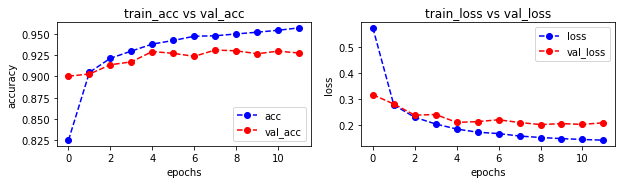

In [101]:
plot_accuracy_loss(history_vgg_fine_tuned)

In [185]:
from tensorflow.keras.metrics import CategoricalAccuracy

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

y_true_all = []
y_pred_all = []

for batch_test in test.as_numpy_iterator():
    X, y = batch_test
    yhat = model_vgg_find_tuned.predict(X, batch_size=128)
    y_pred = np.argmax(yhat,axis=1)
    pre.update_state(y, y_pred)
    re.update_state(y, y_pred)
    y_true_one_hot = tf.one_hot(y, 6)
    acc.update_state(y_true_one_hot, yhat)
    y_true_all = np.concatenate([y_true_all, y])
    y_pred_all = np.concatenate([y_pred_all, y_pred])
    


1/1 [==============================] - 2s 2s/step


In [186]:
print("Precision: {:.4f}, Recall: {:.4f}, Accuracy:{:.4f}".format(pre.result(), re.result(), acc.result()))

Precision: 0.9759, Recall: 0.9657, Accuracy:0.8733


In [104]:
# Use the appropriate evaluation metric for your task (e.g., accuracy, precision, recall)
model_loss, model_accuracy = model_vgg_find_tuned.evaluate(test)
print(f"Test Loss: {model_loss}, Test Accuracy: {model_accuracy}")


20/20 [==============================] - 158s 8s/step - loss: 0.2011 - accuracy: 0.9268
Test Loss: 0.20105022192001343, Test Accuracy: 0.9268491864204407


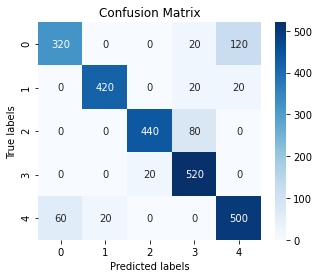

In [105]:
conf_matrix = confusion_matrix(y_true_all, y_pred_all)

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [106]:
# Load the VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# # Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

In [111]:
# Create the head model
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dense(128, activation='relu')(x)
output = Dense(6, activation='softmax')(x) 

In [112]:
# Combine the base and head models
model_vgg_fine_tuned_2 = Model(inputs=base_model.input, outputs=output)

In [113]:
import tensorflow as tf

# Define initial learning rate
initial_learning_rate = 0.0001

# Define decay rate and decay steps
decay_rate = 0.95  # Example decay rate (experiment with different values)
decay_steps = 30  # Example decay steps (adjust based on your training regime)

# Create the learning rate decay schedule
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_rate=decay_rate,
    decay_steps=decay_steps,
    staircase=True  # Set to True for discrete decay at each step
)


In [115]:
# Choose the optimizer (e.g., RMSprop, Adam)
#optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

# Compile the model
model_vgg_fine_tuned_2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [116]:
history_vgg_fine_tuned_2 = model_vgg_fine_tuned_2.fit(train, epochs=15, validation_data = val, callbacks=[callbacks])

Epoch 1/15
72/72 [==============================] - 802s 11s/step - loss: 0.4230 - accuracy: 0.8457 - val_loss: 0.2496 - val_accuracy: 0.9071
Epoch 2/15
72/72 [==============================] - 776s 11s/step - loss: 0.1724 - accuracy: 0.9357 - val_loss: 0.2506 - val_accuracy: 0.9089
Epoch 3/15
72/72 [==============================] - 871s 12s/step - loss: 0.1187 - accuracy: 0.9584 - val_loss: 0.1995 - val_accuracy: 0.9284
Epoch 4/15
72/72 [==============================] - 934s 13s/step - loss: 0.0891 - accuracy: 0.9691 - val_loss: 0.2067 - val_accuracy: 0.9323
Epoch 5/15
72/72 [==============================] - 951s 13s/step - loss: 0.0673 - accuracy: 0.9779 - val_loss: 0.1961 - val_accuracy: 0.9353
Epoch 6/15
72/72 [==============================] - 925s 13s/step - loss: 0.0543 - accuracy: 0.9829 - val_loss: 0.2357 - val_accuracy: 0.9258
Epoch 7/15
72/72 [==============================] - 887s 12s/step - loss: 0.0328 - accuracy: 0.9900 - val_loss: 0.2398 - val_accuracy: 0.9280
Epoch 

In [119]:
model_vgg_fine_tuned_2.save(r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\vgg_model_impr_fine_tuned_2.h5')

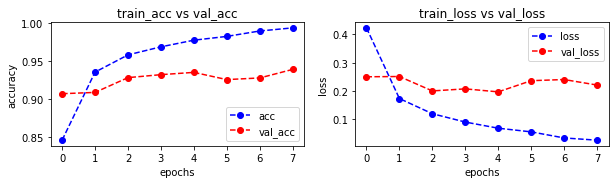

In [120]:
plot_accuracy_loss(history_vgg_fine_tuned_2)

In [121]:
from tensorflow.keras.metrics import CategoricalAccuracy

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

y_true_all = []
y_pred_all = []

for batch in test.as_numpy_iterator():
    X, y = batch_test
    yhat = model_vgg_fine_tuned_2.predict(X, batch_size=128)
    y_pred = np.argmax(yhat,axis=1)
    pre.update_state(y, y_pred)
    re.update_state(y, y_pred)
    y_true_one_hot = tf.one_hot(y, 6)
    acc.update_state(y_true_one_hot, yhat)
    y_true_all = np.concatenate([y_true_all, y])
    y_pred_all = np.concatenate([y_pred_all, y_pred])
    


1/1 [==============================] - 8s 8s/step


In [122]:
print("Precision: {:.4f}, Recall: {:.4f}, Accuracy:{:.4f}".format(pre.result(), re.result(), acc.result()))

Precision: 0.9439, Recall: 0.9619, Accuracy:0.8672


In [126]:
# Use the appropriate evaluation metric for your task (e.g., accuracy, precision, recall)
model_loss, model_accuracy = model_vgg_fine_tuned_2.evaluate(test)
print(f"Test Loss: {model_loss}, Test Accuracy: {model_accuracy}")


20/20 [==============================] - 233s 12s/step - loss: 0.2791 - accuracy: 0.9281
Test Loss: 0.279130756855011, Test Accuracy: 0.9280751943588257


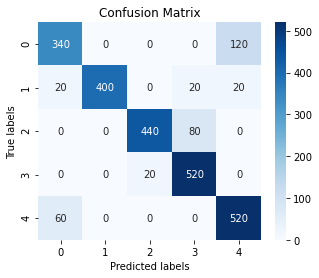

In [125]:
conf_matrix = confusion_matrix(y_true_all, y_pred_all)

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Last improvement

In [6]:
# According to Kaggle the original size if 150*150, therefore we want to keep it as is
data_whole_5_batches = tf.keras.utils.image_dataset_from_directory(r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\seg_train\seg_train', image_size = (150,150), batch_size=2326)

Found 11630 files belonging to 5 classes.


In [9]:
len(data_whole_5_batches)

5

In [7]:
data_whole_5_batches = data_whole_5_batches.map(lambda x, y: (x / 255.0, y))

In [39]:
data_iterator_5 = data_whole_5_batches.as_numpy_iterator()

In [11]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense

# Load the VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# # Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create the head model
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(6, activation='softmax')(x) 

model_vgg_k_fold = Model(inputs=base_model.input, outputs=output)
model_vgg_k_fold.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [31]:
first_batch = next(data_whole_5_batches.as_numpy_iterator())
X_first, y_first = first_batch
print(y_first)
second_batch = next(data_whole_5_batches.as_numpy_iterator())
X_second, y_second = second_batch
print(y_second)
third_batch = next(data_whole_5_batches.as_numpy_iterator())
X_third, y_third = third_batch
print(y_third)
fourth_batch = next(data_whole_5_batches.as_numpy_iterator())
X_fourth, y_fourth = fourth_batch
print(y_fourth)
fifth_batch = next(data_whole_5_batches.as_numpy_iterator())
X_fifth, y_fifth = fifth_batch
print(y_fifth)



[1 1 2 ... 0 2 4]
[4 3 3 ... 1 0 4]
[1 4 1 ... 2 1 4]
[2 2 2 ... 0 2 2]
[4 2 0 ... 0 1 1]


In [12]:
# Assume model is defined and compiled
for val_idx, val_batch in enumerate(data_whole_5_batches.as_numpy_iterator()):
    if val_idx == 0:
        print(f"Validation Batch Index: {val_idx}")
        X_val, y_val = val_batch
        print(y_val)
        print("----------------------------------------------------------------------")
        continue

    train_features_all = []
    train_labels_all = []
    for i, train_batch in enumerate(data_whole_5_batches.as_numpy_iterator()):
        if i != val_idx:
            train_features_all.append(train_batch[0])
            train_labels_all.append(train_batch[1])
    
    train_features_all = np.concatenate(train_features_all, axis=0)
    train_labels_all = np.concatenate(train_labels_all, axis=0)

    # Train the model on all 4 batches
    history_vgg_k_fold = model_vgg_k_fold.fit(train_features_all, train_labels_all, batch_size=128, epochs=5, validation_data=(X_val, y_val), callbacks=[callbacks])
    


Validation Batch Index: 0
[1 4 2 ... 0 2 2]
----------------------------------------------------------------------
Epoch 1/5
73/73 [==============================] - 1350s 18s/step - loss: 0.3845 - accuracy: 0.8583 - val_loss: 0.1965 - val_accuracy: 0.9239
Epoch 2/5
73/73 [==============================] - 1402s 19s/step - loss: 0.1864 - accuracy: 0.9312 - val_loss: 0.1351 - val_accuracy: 0.9540
Epoch 3/5
73/73 [==============================] - 2106s 29s/step - loss: 0.1273 - accuracy: 0.9557 - val_loss: 0.0988 - val_accuracy: 0.9673
Epoch 4/5
73/73 [==============================] - 949s 13s/step - loss: 0.0948 - accuracy: 0.9680 - val_loss: 0.0843 - val_accuracy: 0.9733
Epoch 5/5
73/73 [==============================] - 1070s 15s/step - loss: 0.0714 - accuracy: 0.9758 - val_loss: 0.0816 - val_accuracy: 0.9742


NameError: name 'all_histories' is not defined

In [27]:
all_histories = []

In [28]:
all_histories.append(history_vgg_k_fold)

In [13]:
model_vgg_k_fold.save(r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\vgg_k_fold.h5')

C:\Users\Maya\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


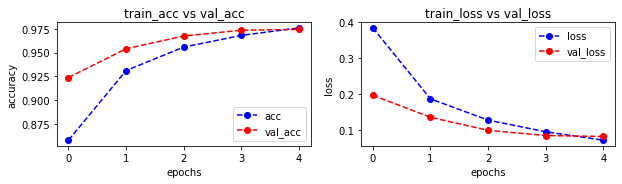

In [14]:
plot_accuracy_loss(history_vgg_k_fold)

In [22]:
from tensorflow.keras.metrics import CategoricalAccuracy

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

y_true_all = []
y_pred_all = []

for batch_test in test.as_numpy_iterator():
    X, y = batch_test
    yhat = model_vgg_k_fold.predict(X, batch_size=128)
    y_pred = np.argmax(yhat,axis=1)
    pre.update_state(y, y_pred)
    re.update_state(y, y_pred)
    y_true_one_hot = tf.one_hot(y, 6)
    acc.update_state(y_true_one_hot, yhat)
    y_true_all = np.concatenate([y_true_all, y])
    y_pred_all = np.concatenate([y_pred_all, y_pred])
    


1/1 [==============================] - 1s 806ms/step


In [23]:
print("Precision: {:.4f}, Recall: {:.4f}, Accuracy:{:.4f}".format(pre.result(), re.result(), acc.result()))

Precision: 0.9745, Recall: 0.9498, Accuracy:0.8566


In [25]:
# Use the appropriate evaluation metric for your task (e.g., accuracy, precision, recall)
model_loss, model_accuracy = model_vgg_k_fold.evaluate(test)
print(f"Test Loss: {model_loss}, Test Accuracy: {model_accuracy}")


20/20 [==============================] - 163s 8s/step - loss: 10.9198 - accuracy: 0.8566
Test Loss: 10.919757843017578, Test Accuracy: 0.8565590381622314


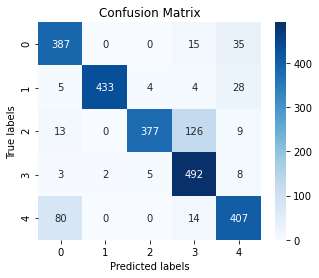

In [26]:
conf_matrix = confusion_matrix(y_true_all, y_pred_all)

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()